In [1]:
import csv
import pickle
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import r2_score,confusion_matrix,mean_squared_error,recall_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn import svm,preprocessing
from sklearn import __version__

print(__version__)

0.19.2


# Preprocessing Data
### 1. Downloading Data

In [2]:
# data = ts.get_h_data('000300', index = True, start = '2015-01-01', end = '2016-01-01')
# data = data.sort_index(ascending=True)#升序
# with open('hs300.pickle','wb') as file:
#     pickle.dump(data, file)

In [3]:
with open('hs300.pickle','rb') as file:
    data = pickle.load(file)
# data.to_csv('/Users/zi-qinzhou/Documents/LearnBySelf/Quant/hs300.csv',encoding='utf-8-sig')
# data = pd.read_csv('hs300.csv') 

In [4]:
data.head()

,open,high,close,low,volume,amount
date,,,,,,
2015-01-05,3566.089,3669.042,3641.541,3551.510,45119811200,519849803776
2015-01-06,3608.428,3683.226,3641.059,3587.231,42096217600,498529599488
2015-01-07,3620.924,3671.190,3643.790,3601.698,32019123200,398731706368
2015-01-08,3650.073,3659.945,3559.259,3552.100,29500304000,355831971840
2015-01-09,3547.574,3689.753,3546.723,3536.395,34998265600,430210580480


### 2. Features Fuction

In [5]:
def CCI(data, ndays):
    TP = (data['high'] + data['low'] + data['close']) / 3
    CCI = pd.Series((TP - pd.DataFrame.rolling(TP, ndays).mean()) / (0.015 * pd.DataFrame.rolling(TP, ndays).std()),
    name = 'CCI')
    result = pd.DataFrame(CCI)
    return result

def EVM(data, ndays):
    dm = ((data['high'] + data['low'])/2) - ((data['high'].shift(1) + data['low'].shift(1))/2)
    br = (data['volume'] / 100000000) / ((data['high'] - data['low']))
    EVM = dm / br
    EVM_MA = pd.Series(pd.DataFrame.rolling(EVM, ndays).mean(), name = 'EVM')
    result = pd.DataFrame(EVM_MA)
    return result

def SMA(data, ndays):
    SMA = pd.Series(pd.DataFrame.rolling(data['close'], ndays).mean(), name = 'SMA')
    result = pd.DataFrame(SMA)
    return result

def ROC(data,n):
    N = data['close'].diff(n)
    D = data['close'].shift(n)
    ROC = pd.Series(N/D,name='Rate of Change')
    result = pd.DataFrame(ROC)
    return result

def BBANDS(data, ndays):
    MA = pd.Series(pd.DataFrame.rolling(data['close'], ndays).mean())
    SD = pd.Series(pd.DataFrame.rolling(data['close'], ndays).std())

    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'Upper BollingerBand')
    data = data.join(B1)

    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'Lower BollingerBand')
    result = pd.DataFrame(B2)
    return result

def ForceIndex(data, ndays): 
    FI = pd.Series(data['close'].diff(ndays) * data['volume'], name = 'ForceIndex') 
    result = pd.DataFrame(FI) 
    return result

### 3. Building Training Datasets

In [6]:
final = pd.concat([CCI(data,5), EVM(data,5), SMA(data,5), ROC(data,5), BBANDS(data,5),ForceIndex(data,5)], axis=1)
final.dropna().head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex
date,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12


In [7]:
temp_target = data.close.diff().apply(lambda x: 1 if x>=0 else 0)
temp_target.head()

date
2015-01-05    0
2015-01-06    0
2015-01-07    1
2015-01-08    0
2015-01-09    0
Name: close, dtype: int64

In [8]:
final['target'] = temp_target
final['train_close'] = data.close
final.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex,target,train_close
date,,,,,,,,
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,0,3641.541
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0,3641.059
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1,3643.790
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,0,3559.259
2015-01-09,-68.98209,NaN,3606.4744,NaN,3508.404329,NaN,0,3546.723


In [9]:
final.dropna(inplace = True)

In [10]:
final.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex,target,train_close
date,,,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12,0,3513.576
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12,1,3514.040
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12,0,3502.423
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12,1,3604.121
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12,1,3635.146


# Training Data

### 1. Let's see what's the data looking like

In [11]:
Y = final.target
X = final.drop(['target','train_close'], axis=1)

print(X.head())
print(Y.head())

                   CCI       EVM        SMA  Rate of Change  \
date                                                          
2015-01-12 -105.969604 -8.018640  3580.8814       -0.035140   
2015-01-13  -62.966672 -8.473673  3555.4776       -0.034885   
2015-01-14  -57.391363 -9.535103  3527.2042       -0.038797   
2015-01-15   45.053627 -3.847704  3536.1766        0.012604   
2015-01-16  108.078685 -0.651911  3553.8612        0.024931   

            Lower BollingerBand    ForceIndex  
date                                           
2015-01-12          3463.650104 -3.411127e+12  
2015-01-13          3448.880974 -2.377211e+12  
2015-01-14          3478.402298 -2.770970e+12  
2015-01-15          3453.304471  1.066874e+12  
2015-01-16          3431.436611  2.499556e+12  
date
2015-01-12    0
2015-01-13    1
2015-01-14    0
2015-01-15    1
2015-01-16    1
Name: target, dtype: int64


### 2. Using random forest to train the data

In [12]:
forest = RandomForestClassifier(n_estimators=10,
                              random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

### 3. Feather importance and sorting the feather list in importance descending order

In [13]:
print(indices)
print(importances)
names = X.columns.tolist()

[0 1 5 3 4 2]
[ 0.29419917  0.1903317   0.0967372   0.14488776  0.11023684  0.16360733]


### 4. Plot the feather importances

Feature ranking:
1. feature CCI (0.294199)
2. feature EVM (0.190332)
3. feature ForceIndex (0.163607)
4. feature Rate of Change (0.144888)
5. feature Lower BollingerBand (0.110237)
6. feature SMA (0.096737)
['CCI', 'EVM', 'ForceIndex', 'Rate of Change', 'Lower BollingerBand', 'SMA']


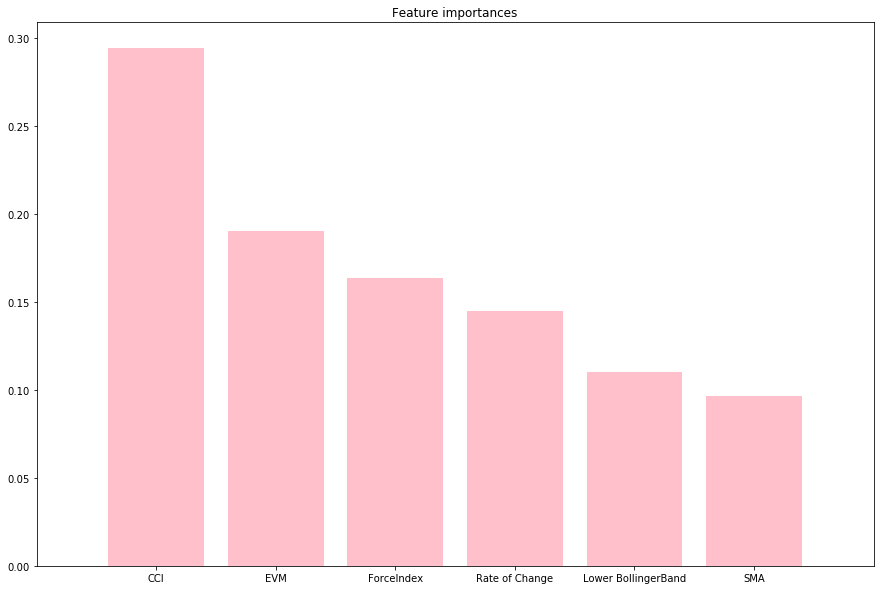

In [14]:
# Print the feature ranking
print("Feature ranking:")
x_pin = []
for f in range(X.shape[1]): 
    print("%d. feature %s (%f)" % (f + 1, names[(indices[f])], importances[indices[f]]))
    x_pin.append(names[indices[f]])

    # Plot the feature importances of the forest
print(x_pin)
plt.figure(1, facecolor='w', figsize=(15, 10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="pink")
plt.xticks(range(X.shape[1]), x_pin)
plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
y = final.drop(['CCI','EVM','Rate of Change','Lower BollingerBand', 'ForceIndex','SMA','train_close'], axis=1)
y.head()

,target
date,
2015-01-12,0
2015-01-13,1
2015-01-14,0
2015-01-15,1
2015-01-16,1


In [16]:
# used for classification, not regression
y = np.array(y)
y = y.ravel()

In [17]:
X.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex
date,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12


## Plot confusion matrix using the model Random Forest

In [18]:
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=0)
# scoring = ['precision_macro', 'recall_macro']
# clf = svm.SVC(kernel='linear', C=1, random_state=0)
# scores = cross_validate(clf, X, y, scoring=scoring,cv=5, return_train_score=False)
# scores['test_recall_macro']                       

In [19]:
classifier = RandomForestClassifier(n_estimators=11,random_state=0)
# classifier = svm.SVC()

In [41]:
# y_train.head()

In [42]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
classifier.score(X_test, y_test)

0.75

In [24]:
confusion_matrix(y_pred, y_test)

array([[22,  9],
       [ 6, 23]])

Confusion matrix, without normalization
[[22  6]
 [ 9 23]]
Normalized confusion matrix
[[ 0.79  0.21]
 [ 0.28  0.72]]


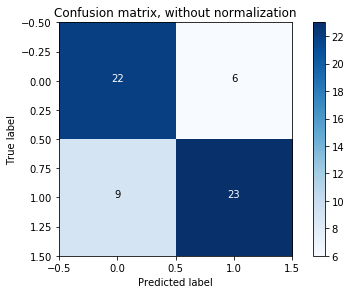

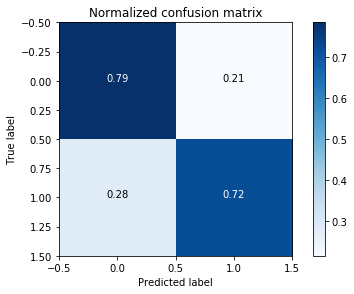

In [25]:
import itertools
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [26]:
r2_score(y_test, y_pred)

-0.0044642857142855874

In [27]:
mean_squared_error(y_test, y_pred)

0.25

# Prediction 

In [28]:
with open('hs300.pickle','rb') as file:
    test = pickle.load(file)

In [29]:
preprocessing.scale(test)

/Users/zi-qinzhou/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[-0.64, -0.55, -0.52, -0.58,  1.2 ,  0.64],
       [-0.56, -0.53, -0.52, -0.51,  0.98,  0.53],
       [-0.54, -0.55, -0.51, -0.49,  0.22,  0.03],
       ..., 
       [-0.36, -0.39, -0.3 , -0.28, -1.42, -1.26],
       [-0.29, -0.38, -0.3 , -0.26, -1.39, -1.18],
       [-0.29, -0.37, -0.36, -0.25, -1.42, -1.24]])

In [30]:
final.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex,target,train_close
date,,,,,,,,
2015-01-12,-105.969604,-8.018640,3580.8814,-0.035140,3463.650104,-3.411127e+12,0,3513.576
2015-01-13,-62.966672,-8.473673,3555.4776,-0.034885,3448.880974,-2.377211e+12,1,3514.040
2015-01-14,-57.391363,-9.535103,3527.2042,-0.038797,3478.402298,-2.770970e+12,0,3502.423
2015-01-15,45.053627,-3.847704,3536.1766,0.012604,3453.304471,1.066874e+12,1,3604.121
2015-01-16,108.078685,-0.651911,3553.8612,0.024931,3431.436611,2.499556e+12,1,3635.146


In [31]:
start_date = '2015-10-01'

In [32]:
y2 = final.drop(['CCI','EVM','Rate of Change','Lower BollingerBand', 'ForceIndex','SMA','target'], axis=1)
y2.head()

,train_close
date,
2015-01-12,3513.576
2015-01-13,3514.040
2015-01-14,3502.423
2015-01-15,3604.121
2015-01-16,3635.146


In [33]:
x2_train = X[X.index < start_date]
x2_train.tail()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex
date,,,,,,
2015-09-24,-10.153031,-1.735417,3289.3154,0.014829,3218.697910,4.896540e+11
2015-09-25,-79.793565,-2.294854,3285.4510,-0.005943,3203.258469,-2.346063e+11
2015-09-28,-72.542749,-8.418229,3272.3520,-0.019797,3187.491879,-4.861004e+11
2015-09-29,-97.232991,-19.139505,3240.3168,-0.047971,3160.530271,-1.395944e+12
2015-09-30,-39.663326,-11.742948,3228.3008,-0.018412,3147.525819,-4.719846e+11


In [34]:
x2_test = X[X.index >= start_date]
x2_test.head()

,CCI,EVM,SMA,Rate of Change,Lower BollingerBand,ForceIndex
date,,,,,,
2015-10-08,105.835813,-4.034310,3230.5974,0.003496,3141.534412,1.516695e+11
2015-10-09,80.471580,1.329778,3252.2304,0.033467,3119.622806,1.345059e+12
2015-10-12,91.576915,17.966904,3293.2186,0.063200,3075.732051,4.537403e+12
2015-10-13,66.807236,22.524810,3346.4564,0.083737,3138.849875,3.871288e+12
2015-10-14,41.305199,20.332971,3387.0892,0.063430,3253.637049,3.091627e+12


In [35]:
y2_train = y2[y2.index < start_date]
y2_train.tail()

,train_close
date,
2015-09-24,3284.999
2015-09-25,3231.951
2015-09-28,3242.752
2015-09-29,3178.854
2015-09-30,3202.948


In [36]:
y2_test = y2[y2.index >= start_date]
y2_test.head()

,train_close
date,
2015-10-08,3296.482
2015-10-09,3340.116
2015-10-12,3447.693
2015-10-13,3445.043
2015-10-14,3406.112


## Grid Search for Ridge Regression

In [37]:
para_list = [{'alpha': [1.2, 1.1, 1.0, 0.9, 0.8]}]
model_2 = GridSearchCV(Ridge(), para_list, cv=10)
model_2.fit(x2_train,y2_train)

/Users/zi-qinzhou/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.048392383449219e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/zi-qinzhou/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.01806073384226e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/zi-qinzhou/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.366671053773139e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/zi-qinzhou/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1.2, 1.1, 1.0, 0.9, 0.8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
y2_pred = model_2.predict(x2_test)

In [39]:
r2_score(y2_test, y2_pred)

0.93918753344689399

### Blue line is the true value for the stockmarket
### Yellow line is the predicted value

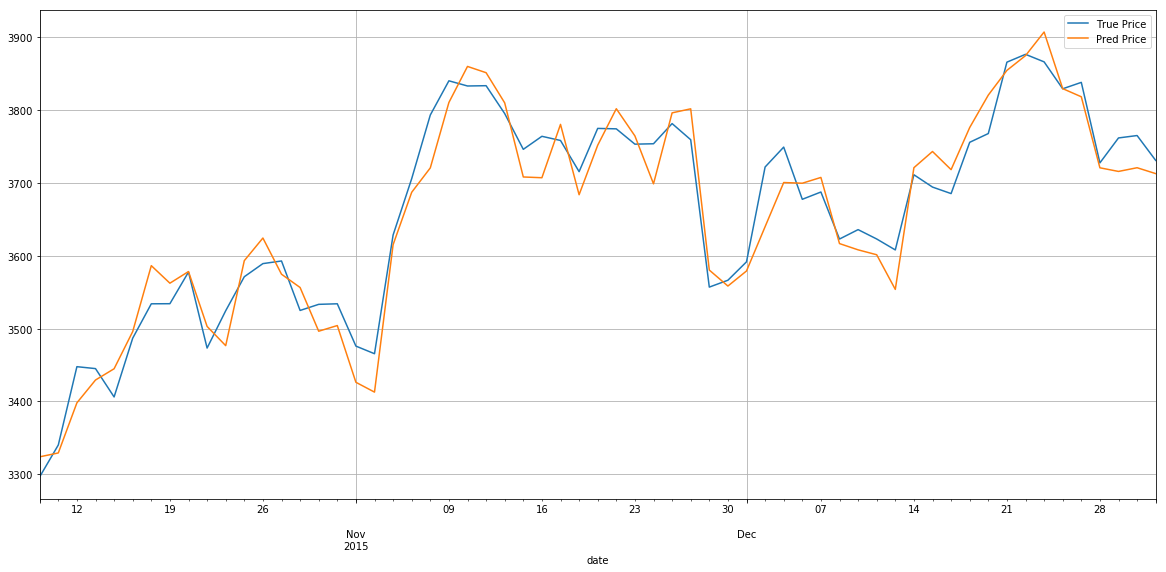

In [40]:
result = pd.DataFrame(index = y2_test.index)
result['True Price'] = y2_test
result['Pred Price'] = y2_pred
result.plot(figsize = (20,9),grid = True)
plt.show()